In [1]:
from anndata import AnnData
from main import integrate_data
from utils import data_preprocess

import scanpy as sc
import numpy as np
import time
import os

In [2]:
input_dir = 'input'
res_dir = 'result'
method_name = 'IMG'
data_name = 'DC'

In [3]:
start_time = time.time()
adata = sc.read_loom("../data/DC.loom",sparse = False)
# adata = sc.read_loom("../mycode/myintegrate/data/panc8.loom",sparse = False)

In [4]:
adata.obs['batch'] = adata.obs['batch'].astype('category')

In [5]:
adata.obs.batch.value_counts()

Batch2    286
Batch1    283
Name: batch, dtype: int64

In [6]:
adata.X = np.float32(np.int32(adata.X))
adata = data_preprocess(adata)

/hpcfiles/users/zcg/.conda/envs/zcg/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
Trying to set attribute `.obs` of view, copying.


Establishing Adata for Next Step...
PreProcess Done.


In [7]:
balance_sampling = False
batch_num = len(adata.obs.batch.unique())

In [8]:
# Whether to use batch balance sampling strategy
if balance_sampling:
    total_num = len(adata)
    per_num = int(total_num/batch_num)

    X = adata.X
    y = adata.obs.batch.tolist()

    from collections import Counter
    print(Counter(y))

    over_sample = {}
    under_sample = {}
    dict_y = Counter(y)
    for key in dict_y.keys():
        if dict_y[key] >= per_num * 1.1:
            under_sample[key] = int(per_num * 1.1)
        elif dict_y[key] <= per_num * 0.9:
            over_sample[key] = int(per_num * 0.9)

    from imblearn.over_sampling import SMOTE
    smo = SMOTE(sampling_strategy=over_sample,random_state=42)
    X_smo, y_smo = smo.fit_resample(X, y)
    print(Counter(y_smo))

    from imblearn.under_sampling import RandomUnderSampler
    cc = RandomUnderSampler(sampling_strategy=under_sample,random_state=0)
    X_resampled, y_resampled = cc.fit_resample(X_smo, y_smo)
    print(Counter(y_resampled))
    import pandas as pd
    obs = pd.DataFrame()
    obs['batch'] = y_resampled
    ppd_adata = AnnData(X_resampled,obs=obs)
else:
    ppd_adata = adata

In [9]:
sc.tl.pca(ppd_adata,n_comps=256)

In [10]:
out= integrate_data(ppd_adata, adata, batch_key='batch', n_epochs=100, mnn_times=2, len_weight=5, self_nbs=5, other_nbs=1, batch_size=1024, n_critic=100,batch_num=batch_num,balance_sampling=balance_sampling)

Number of samples per batch: 282
Times: 0
Batch1<——>Batch2
Times: 1
Batch1<——>Batch2


/hpcfiles/users/zcg/.conda/envs/zcg/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


Find MNNs time-consuming :0.25588154792785645
The percentage of MNN paired cells in the total cells : 0.21631205673758866
The final number of subgraphs :61
Counter({2: 61})
Dataset size : 1220
Time-consuming to build dataset: 1.9210035800933838
[Epoch 1/100] [D loss: -0.031692] [G loss: 0.097221] [AE loss: 100.820206]
[Epoch 2/100] [D loss: -0.828391] [G loss: -0.554013] [AE loss: 75.973663]
[Epoch 3/100] [D loss: -1.629035] [G loss: -2.407733] [AE loss: 66.216202]
[Epoch 4/100] [D loss: -1.999774] [G loss: -4.466070] [AE loss: 66.057533]
[Epoch 5/100] [D loss: -2.063716] [G loss: -4.963454] [AE loss: 60.775158]
[Epoch 6/100] [D loss: -2.131478] [G loss: -4.665086] [AE loss: 62.329914]
[Epoch 7/100] [D loss: -2.192067] [G loss: -4.350624] [AE loss: 61.842773]
[Epoch 8/100] [D loss: -2.198714] [G loss: -4.081671] [AE loss: 59.557693]
[Epoch 9/100] [D loss: -2.268348] [G loss: -4.020391] [AE loss: 59.321087]
[Epoch 10/100] [D loss: -2.360218] [G loss: -4.189776] [AE loss: 62.065899]
[Epo

In [11]:
end_time = time.time()
print("耗时为: "+str(end_time-start_time))

耗时为: 83.06577587127686


In [12]:
out = AnnData(out,adata.obs)

In [13]:
out.write_loom(os.path.join(res_dir,method_name+'_'+data_name+'.loom'),write_obsm_varm=True)

In [14]:
sc.pp.neighbors(out)
sc.tl.umap(out)

         Falling back to preprocessing with `sc.pp.pca` and default params.


... storing 'ClusterName' as categorical
... storing 'celltype' as categorical


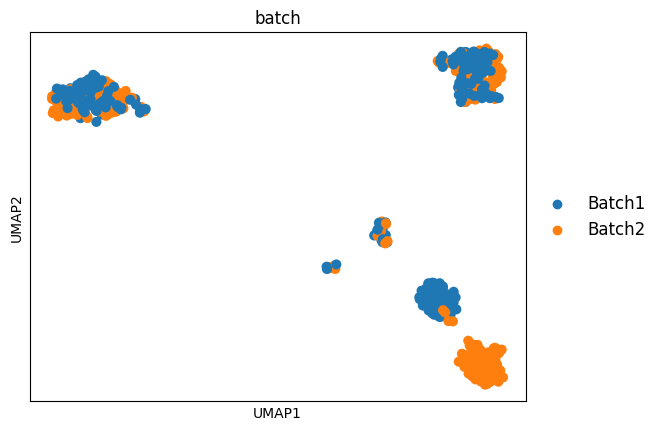

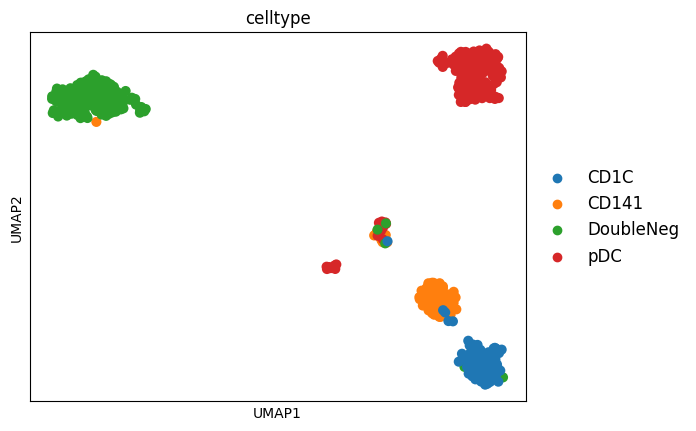

In [15]:
sc.pl.umap(out,color=['batch'],legend_fontsize=12,save='_'+method_name+'_'+data_name+'_batch.png')
sc.pl.umap(out,color=['celltype'],legend_fontsize=12,save='_'+method_name+'_'+data_name+'_celltype.png')

In [16]:
out = out[out.obs.celltype != 'CD1C']
out = out[out.obs.celltype != 'CD141']

/hpcfiles/users/zcg/.conda/envs/zcg/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [17]:
import pandas as pd

from sklearn.metrics import silhouette_score,adjusted_rand_score
from sklearn.cluster import KMeans

def compute_asw(arr, batch_label, cell_label):

    batch_score = silhouette_score(arr, batch_label)
    celltype_score = silhouette_score(arr, cell_label)


    return batch_score,celltype_score

def compute_ARI(adata):
    
    X = adata.obsm['X_pca']
    Y_batchcluster = adata.obs['batch'].tolist()
    Y_batchnum = len(set(Y_batchcluster))

    Y_cellcluster = adata.obs['celltype'].tolist()
    Y_cellnum = len(set(Y_cellcluster))

    km_batch = KMeans(n_clusters=Y_batchnum, init='k-means++', max_iter=30)
    km_batch.fit(X)
    y_batch = km_batch.predict(X)
    batch_ARI = adjusted_rand_score(Y_batchcluster,y_batch)


    km_cell = KMeans(n_clusters=Y_cellnum, init='k-means++', max_iter=30)
    km_cell.fit(X)
    y_cell = km_cell.predict(X)
    cell_ARI = adjusted_rand_score(Y_cellcluster,y_cell)

    return batch_ARI, cell_ARI

In [18]:
arr = out.obsm['X_pca']
batch_label = out.obs['batch'].tolist()
cell_label = out.obs['celltype'].tolist()
asw_batch_score, asw_celltype_score = compute_asw(arr, batch_label, cell_label)
print(asw_batch_score,asw_celltype_score)

0.0002288997 0.5908694


In [19]:
batch_ARI, cell_ARI = compute_ARI(out)
print(batch_ARI, cell_ARI)

-0.002602236938740621 0.9788361503093974


In [20]:
matrix_path = os.path.join(res_dir,method_name+'_'+data_name+'_matrix.csv')
meta_path = os.path.join(res_dir,method_name+'_'+data_name+'_meta.csv')
lisi_path = os.path.join(res_dir,method_name+'_'+data_name+'_lisi.csv')

np.savetxt(matrix_path, out.obsm['X_pca'], delimiter=',')
data = {'batch':out.obs.batch.tolist(), 'celltype':out.obs.celltype.tolist()}
df = pd.DataFrame(data)
df.to_csv(meta_path,index=False)

process_args = "~/.conda/envs/zcg/bin/Rscript LISI.R "+matrix_path+" "+meta_path+" "+lisi_path
print(os.popen(process_args).read())

[1] "batch mean LISI: "
[1] 1.920626
[1] "celltype mean LISI: "
[1] 1.017606

